<a href="https://colab.research.google.com/github/josooik/DeepLearning/blob/main/segmentation_advence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation with advence

## 데이터셋: Oxford-IIIT Pets 데이터셋
---
![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/oxford-pet.jpeg?raw=true)

### 1. 데이터셋 다운로드

In [2]:
!curl -O  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  11.0M      0  0:01:08  0:01:08 --:--:-- 11.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  3961k      0  0:00:04  0:00:04 --:--:-- 4442k


### 2. 이미지 경로 설정

In [3]:
import os
from glob import glob

data_dir = '/content/'

# Training
train_img_path = glob(os.path.join(data_dir, 'images/*.jpg'))
train_mask_path = glob(os.path.join(data_dir, 'annotations/trimaps/*.png'))
print("Training_Img :", len(train_img_path))
print("Training_Mask :", len(train_mask_path))

# Training Sort
train_img_path_sort = sorted(train_img_path)
train_mask_path_sort = sorted(train_mask_path)
print("Train_Img_path_sort :", train_img_path_sort[:2])
print("Train_Mask_path :", train_mask_path_sort[:2])

Training_Img : 7390
Training_Mask : 7390
Train_Img_path_sort : ['/content/images/Abyssinian_1.jpg', '/content/images/Abyssinian_10.jpg']
Train_Mask_path : ['/content/annotations/trimaps/Abyssinian_1.png', '/content/annotations/trimaps/Abyssinian_10.png']


## 데이터셋 제너레이터
---

### 함수

In [81]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class DataGenerator():
  def __init__(self, img_size, batch_size):
    self.img_size = img_size
    self.batch_size = batch_size

  def path2arr(self, path, mask=False):
    # img 일때
    if not mask:
      # path -> img
      img = load_img(path, color_mode='rgb', target_size=(self.img_size, self.img_size))
      # img -> arr
      arr = img_to_array(img, dtype='uint8')
    
    # mask 일때
    else:
      # path -> img
      img = load_img(path, color_mode='grayscale', target_size=(self.img_size, self.img_size))
      # img -> arr
      arr = img_to_array(img, dtype='uint8')

    return arr
  
  def load_datasets(self, img_paths, mask_paths):
    img_arrs = []
    mask_arrs = []

    for img_path, mask_path in zip(img_paths, mask_paths):
      img_arr = self.path2arr(img_path)
      img_arrs.append(img_arr)

      mask_arr = self.path2arr(mask_path, mask=True)
      mask_arrs.append(mask_arr)
    
    return np.array(img_arrs), np.array(mask_arrs)
  
  def preprocess(self, img_arr, mask_arr):
    img_arr = (img_arr / 127.5) -1
    mask_arr = mask_arr - 1

    return img_arr, mask_arr
  
  def tf_preprocess(self, img_arr, mask_arr):
    img_arr = (tf.cast(img_arr, tf.float32) / 127.5) -1
    mask_arr = tf.cast(mask_arr, tf.float32) -1 # int -> float

    return img_arr, mask_arr
  
  def augment(slef, img, mask):
    # 밝기랜덤조절
    img = tf.image.random_brightness(img, max_delta=0.5)
    img = tf.clip_by_value(img, -1, 1)

    ds = tf.concat((img, mask), axis=2)
    # 좌우랜덤반전 / 상하랜덤반전
    ds = tf.image.random_flip_left_right(ds)
    ds = tf.image.random_flip_up_down(ds)
    
    # 이미지 사이즈 증가(padding)
    #pd_size = 50
    #img = tf.image.resize_with_crop_or_pad(img, self.img_size + pad_size, self.img_size + pad_size)
    #mask = tf.mask.resize_with_crop_or_pad(mask, self.img_size + pad_size, self.img_size + pad_size)

    # 랜덤크롭
    #ds = tf.cncat((img, mask), axis=2)
    #ds = tf.image.random_crop(ds, size=[self.img_size, self.img_size, 4])
    img, mask = ds[:,:,:3], ds[:,:,-1]
    # img = (256, 256, 3)
    # mask = (256, 256) -> (256, 256,1)
    mask = tf.expand_dims(mask, axis=2)

    return img, mask

  def generate(self, img_paths, mask_paths, aug=False):
    # 기존 Numpy 이용한 데이터셋 처리
    img_arrs, mask_arrs = self.load_datasets(img_paths, mask_paths)

    # tensorflow dataset 라이브러리 사용 여기서부터는 Numpy가 아니라 Tensor 이용
    dataset = tf.data.Dataset.from_tensor_slices((img_arrs, mask_arrs))
    dataset = dataset.map(self.tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE) # 전처리, num_parallel_calls=tf.data.AUTOTUNE -> 병렬처리
    
    if aug:
      dataset.map(self.augment, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(self.batch_size, drop_remainder=True) # batch 사이즈 지정
    print(dataset)

    return dataset

In [82]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

def hist_val(img_arr, mask_arr):
  plt.figure(figsize=(10,4))

  plt.subplot(1,2,1)
  img_shape = img_arr.shape[0] * img_arr.shape[1] * img_arr.shape[2]
  plt.hist(np.reshape(img_arr, img_shape)) # 1차원인풋

  plt.subplot(1,2,2)
  mask_shape = mask_arr.shape[0] * mask_arr.shape[1] * mask_arr.shape[2]
  plt.hist(np.reshape(mask_arr, mask_shape)) # 1차원인풋
  print('* # of mask categories :', set(np.reshape(mask_arr, mask_shape))) # set 중복 제거, mask의 카테고리 확인

  plt.show()

def display_img(img_arr, mask_arr, mask_cmap=None):
  plt.figure(figsize=(12,4))

  plt.subplot(1,3,1)
  plt.axis('off')
  plt.imshow(img_arr)

  plt.subplot(1,3,2)
  plt.axis('off')
  plt.imshow(img_arr)
  plt.imshow(mask_arr[:,:,0], alpha=0.6, cmap=mask_cmap) # mask_arr (가로, 세로, 1) -> (가로, 세로)

  plt.subplot(1,3,3)
  plt.axis('off')
  plt.imshow(mask_arr[:,:,0], cmap=mask_cmap) # mask_arr (가로, 세로, 1) -> (가로, 세로)
  
  plt.show()

### 정의

In [83]:
IMG_SIZE = 256
BATCH_SIZE = 16
dg = DataGenerator(IMG_SIZE, BATCH_SIZE)

### 1. array 변환

In [150]:
idx = 12

img_arr = dg.path2arr(train_img_path_sort[idx])
mask_arr = dg.path2arr(train_mask_path_sort[idx], mask=True)

print(img_arr.shape, mask_arr.shape)

(256, 256, 3) (256, 256, 1)


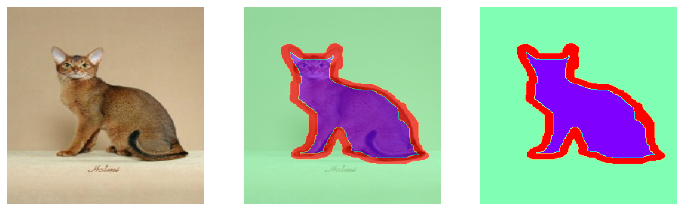

In [151]:
display_img(img_arr, mask_arr, mask_cmap='rainbow')

* # of mask categories : {1, 2, 3}


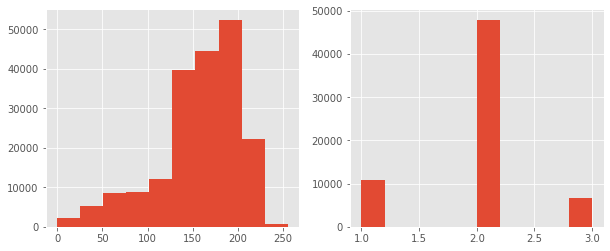

In [152]:
hist_val(img_arr, mask_arr)

### 2. 전처리

In [153]:
img_pre, mask_pre = dg.preprocess(img_arr, mask_arr)
print(img_pre.shape, mask_pre.shape)

(256, 256, 3) (256, 256, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


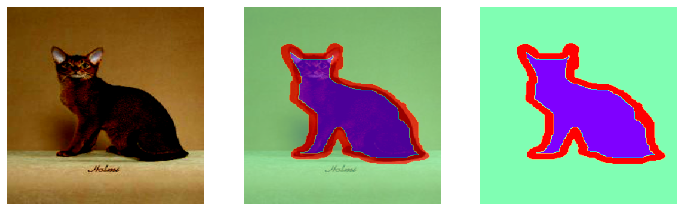

In [154]:
display_img(img_pre, mask_pre, mask_cmap='rainbow')

* # of mask categories : {0, 1, 2}


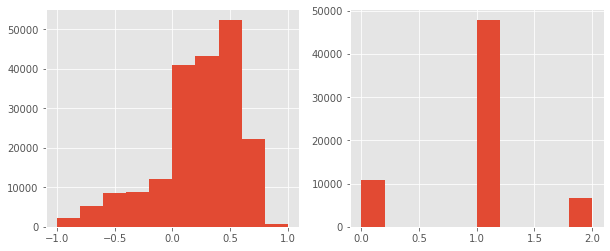

In [155]:
hist_val(img_pre, mask_pre)

### 3. 데이터셋 정의


In [156]:
train_ds = dg.generate(train_img_path_sort[:5000], train_mask_path_sort[:5000])
valid_ds = dg.generate(train_img_path_sort[5000:], train_mask_path_sort[5000:])

print("* Train_ds :", train_ds)
print("* Vrain_ds :", valid_ds)

<BatchDataset shapes: ((16, 256, 256, 3), (16, 256, 256, 1)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((16, 256, 256, 3), (16, 256, 256, 1)), types: (tf.float32, tf.float32)>
* Train_ds : <BatchDataset shapes: ((16, 256, 256, 3), (16, 256, 256, 1)), types: (tf.float32, tf.float32)>
* Vrain_ds : <BatchDataset shapes: ((16, 256, 256, 3), (16, 256, 256, 1)), types: (tf.float32, tf.float32)>


## 모델: UNet
---

![]( https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/unet2.png?raw=true)

### 1. 모델 생성

In [157]:
from tensorflow.keras import layers, models, Input, utils

def get_unet(img_size, num_classes):
  inputs = Input(shape=(img_size, img_size, 3))

  x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x_pre = x

  for filters in [64, 128, 256]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    residual = layers.Conv2D(filters, 1, strides=2, padding='same')(x_pre)
    x = layers.add([x, residual])
    x_pre = x

  for filters in [256, 128, 64, 32]:
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)

    residual = layers.UpSampling2D(2)(x_pre)
    residual = layers.Conv2D(filters, 1, padding='same')(residual)
    x = layers.add([x, residual])
    x_pre = x

  outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

  model = models.Model(inputs, outputs)
  return model

### 2. 모델 컴파일

In [158]:
NUM_CLASSES = 3
model = get_unet(IMG_SIZE, NUM_CLASSES)

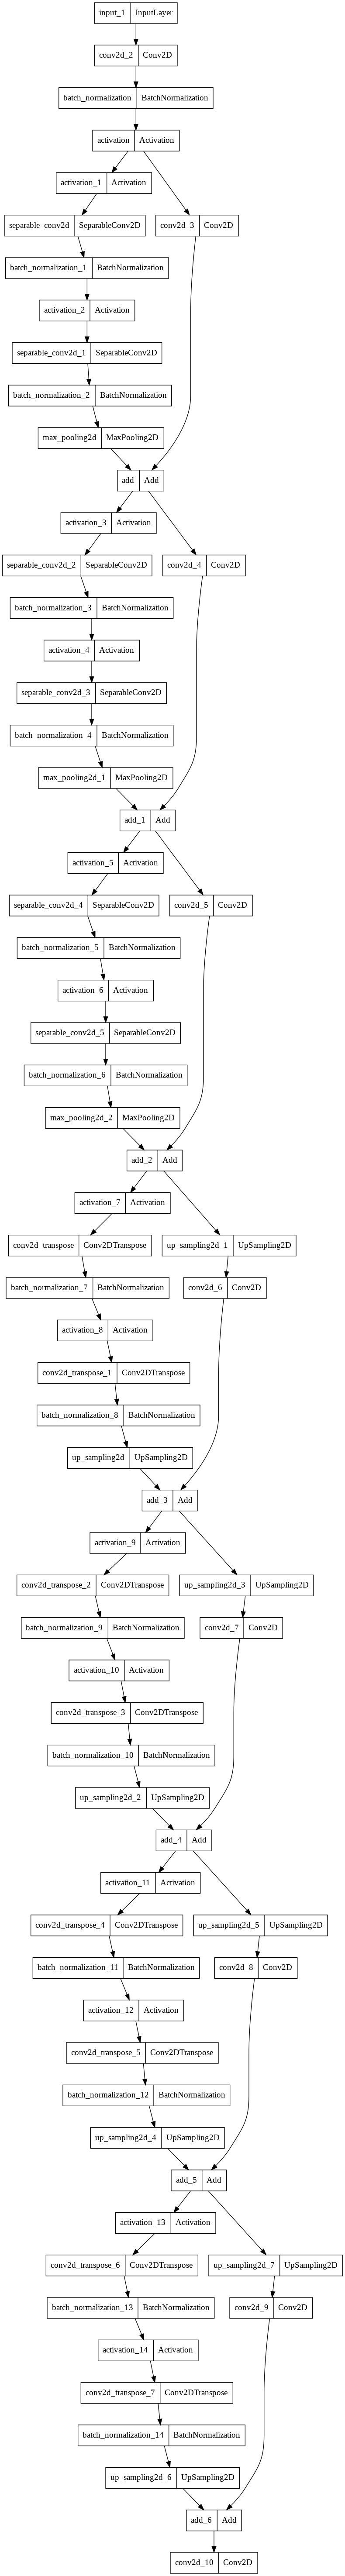

In [159]:
tf.keras.utils.plot_model(model)

In [160]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss=loss,
              optimizer = optimizer,
              metrics = ['accuracy'])

### 3. 모델 학습

In [161]:
ckp = tf.keras.callbacks.ModelCheckpoint("unet_chip_1.h5", save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2, # 0.2씩 lr 줄이기
                                                 patience=5) # 5번동안 loss 안줄면



In [162]:
history = model.fit(train_ds,
                    validation_data = valid_ds,
                    epochs=20,
                    callbacks=[ckp]) # 학습성능 향상 시키는 모듈

Epoch 1/20
312/312 [==============================] - ETA: 0s - loss: 0.7813 - accuracy: 0.7183

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


312/312 [==============================] - 180s 569ms/step - loss: 0.7813 - accuracy: 0.7183 - val_loss: 4.7370 - val_accuracy: 0.6014
Epoch 2/20
312/312 [==============================] - 193s 620ms/step - loss: 0.5589 - accuracy: 0.7757 - val_loss: 0.5871 - val_accuracy: 0.7822
Epoch 3/20
312/312 [==============================] - 176s 563ms/step - loss: 0.4937 - accuracy: 0.8043 - val_loss: 0.4923 - val_accuracy: 0.8159
Epoch 4/20
312/312 [==============================] - 176s 563ms/step - loss: 0.4512 - accuracy: 0.8222 - val_loss: 0.4646 - val_accuracy: 0.8284
Epoch 5/20
312/312 [==============================] - 175s 561ms/step - loss: 0.4177 - accuracy: 0.8358 - val_loss: 0.5204 - val_accuracy: 0.8175
Epoch 6/20
312/312 [==============================] - 175s 559ms/step - loss: 0.3911 - accuracy: 0.8469 - val_loss: 0.5069 - val_accuracy: 0.8251
Epoch 7/20
312/312 [==============================] - 175s 560ms/step - loss: 0.3659 - accuracy: 0.8567 - val_loss: 0.5173 - val_accura

### 모델 시각화

In [163]:
def plot_leraning_curve(H):
    N = len(H.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N),  H.history["loss"], label="train_loss", marker='o',)
    plt.plot(np.arange(0, N),  H.history["val_loss"], label="val_loss", marker='o')
    plt.plot(np.arange(0, N),  H.history["accuracy"], label="train_acc", marker='o')
    plt.plot(np.arange(0, N),  H.history["val_accuracy"], label="val_acc", marker='o')
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig("lerning_curve")
    plt.show()

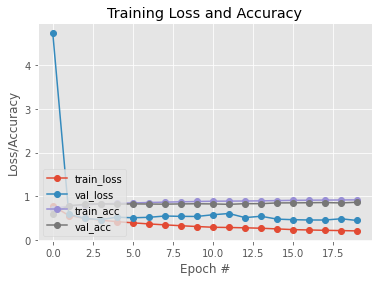

In [164]:
plot_leraning_curve((history))

### 4. 모델 평가

In [165]:
model.evaluate(valid_ds)

149/149 [==============================] - 24s 158ms/step - loss: 0.4449 - accuracy: 0.8621


[0.4448930323123932, 0.8620558381080627]

### 5. 추론

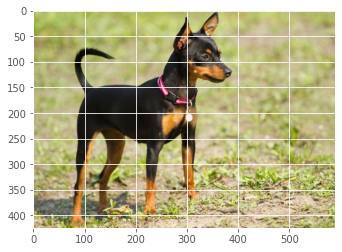

In [167]:
import matplotlib.pyplot as plt

img = plt.imread("dog.jfif")

plt.imshow(img)
plt.show()

In [168]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models

def img_predict(path, model, mask_cmap=None):
  # path -> arr
  img_arr = dg.path2arr(path)
  # arr -> 전처리
  img_pre, _ = dg.preprocess(img_arr, img_arr)
  img_pre.shape

  # 모델예측
  pred = model.predict(tf.expand_dims(img_pre, 0))
  print(pred.shape)

  pred = np.argmax(pred, axis=3)
  print(pred.shape)

  pred = np.expand_dims(pred[0],2)
  print(pred.shape)

  # 디스플레이
  display_img(img_arr, pred)

(1, 256, 256, 3)
(1, 256, 256)
(256, 256, 1)


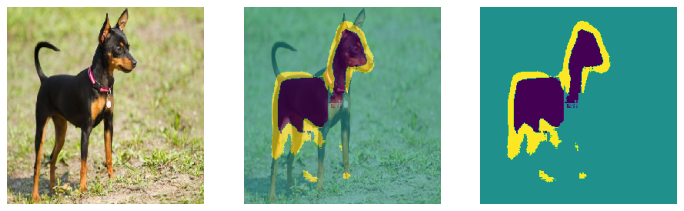

(1, 256, 256, 3)
(1, 256, 256)
(256, 256, 1)


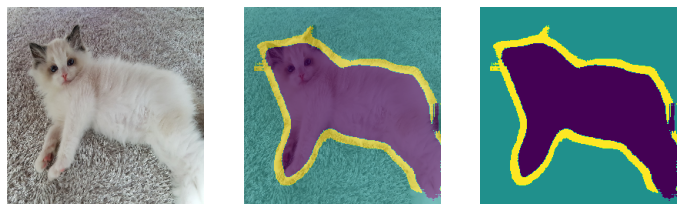

In [171]:
img_predict('dog.jfif', model, mask_cmap='rainbow')
img_predict('cat.jpeg', model, mask_cmap='rainbow')

## Generator with augmentation
---


### augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3) (256, 256, 1)


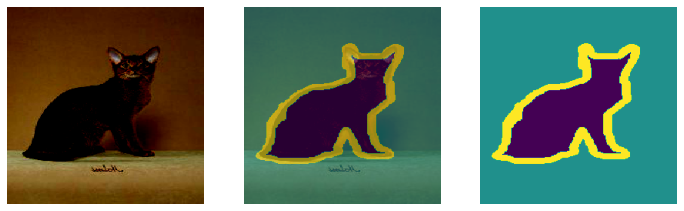

* # of mask categories : {0.0, 1.0, 2.0}


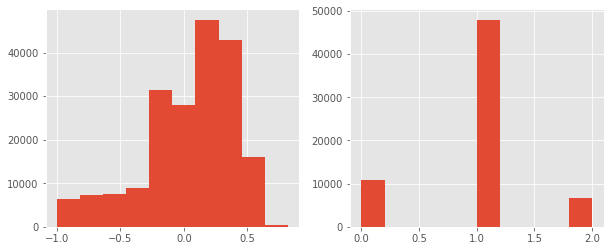

In [116]:
img_aug, mask_aug = dg.augment(img_pre, mask_pre)
print(img_aug.shape, mask_aug.shape)
display_img(img_aug, mask_aug)
hist_val(img_aug, mask_aug)

### 데이터셋 정의

In [117]:
train_ds = dg.generate(train_img_path_sort[:5000], train_mask_path_sort[:5000], aug=True)
valid_ds = dg.generate(train_img_path_sort[5000:], train_mask_path_sort[5000:])

print("* Train_ds :", train_ds)
print("* Vrain_ds :", valid_ds)

<BatchDataset shapes: ((16, 256, 256, 3), (16, 256, 256, 1)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((16, 256, 256, 3), (16, 256, 256, 1)), types: (tf.float32, tf.float32)>
* Train_ds : <BatchDataset shapes: ((16, 256, 256, 3), (16, 256, 256, 1)), types: (tf.float32, tf.float32)>
* Vrain_ds : <BatchDataset shapes: ((16, 256, 256, 3), (16, 256, 256, 1)), types: (tf.float32, tf.float32)>


## 모델: 전이학습

### 1. 모델 생성

In [118]:
base_model = tf.keras.models.load_model("unet_chip.h5")
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [122]:
from tensorflow.keras import models, layers

NUM_CLASSES = 3
Kernel_SIZE = 3

input = base_model.input # (256,256,3)
output = base_model.layers[-2].output
output = layers.Conv2D(NUM_CLASSES, Kernel_SIZE, activation='softmax', padding='same', name='new_layer')(output)

model = models.Model(inputs=input, outputs=output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

### 2. 모델 컴파일

In [140]:
from tensorflow.keras import losses, optimizers

loss = losses.SparseCategoricalCrossentropy() 
optimizer = optimizers.Adam(learning_rate=0.001)

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

### 3. 모델 학습

In [141]:
from tensorflow.keras import callbacks

In [146]:
es = callbacks.EarlyStopping(monitor='val_loss')

ckp = callbacks.ModelCheckpoint('unet_pet_aug.h5',
                                      monitor='val_loss',
                                      verbose=0,
                                      save_best_only=True)

lr = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.1,
                                          patience=10)

history = model.fit(train_ds,
                    validation_data = valid_ds,
                    epochs=20,
                    callbacks=[ckp, lr]) # 학습 효과적으로

Epoch 1/20
312/312 [==============================] - ETA: 0s - loss: 0.2581 - accuracy: 0.9014

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


312/312 [==============================] - 177s 566ms/step - loss: 0.2581 - accuracy: 0.9014 - val_loss: 0.3171 - val_accuracy: 0.8838 - lr: 0.0010
Epoch 2/20
312/312 [==============================] - 195s 625ms/step - loss: 0.2238 - accuracy: 0.9136 - val_loss: 0.3305 - val_accuracy: 0.8814 - lr: 0.0010
Epoch 3/20
312/312 [==============================] - 173s 554ms/step - loss: 0.1983 - accuracy: 0.9221 - val_loss: 0.3407 - val_accuracy: 0.8845 - lr: 0.0010
Epoch 4/20
312/312 [==============================] - 173s 553ms/step - loss: 0.1862 - accuracy: 0.9259 - val_loss: 0.3548 - val_accuracy: 0.8859 - lr: 0.0010
Epoch 5/20
312/312 [==============================] - 173s 555ms/step - loss: 0.1779 - accuracy: 0.9286 - val_loss: 0.3714 - val_accuracy: 0.8863 - lr: 0.0010
Epoch 6/20
312/312 [==============================] - 173s 556ms/step - loss: 0.1655 - accuracy: 0.9331 - val_loss: 0.3609 - val_accuracy: 0.8899 - lr: 0.0010
Epoch 7/20
312/312 [==============================] - 173

### 모델 시각화

In [147]:
def plot_leraning_curve(H):
    N = len(H.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N),  H.history["loss"], label="train_loss", marker='o',)
    plt.plot(np.arange(0, N),  H.history["val_loss"], label="val_loss", marker='o')
    plt.plot(np.arange(0, N),  H.history["accuracy"], label="train_acc", marker='o')
    plt.plot(np.arange(0, N),  H.history["val_accuracy"], label="val_acc", marker='o')
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig("lerning_curve")
    plt.show()

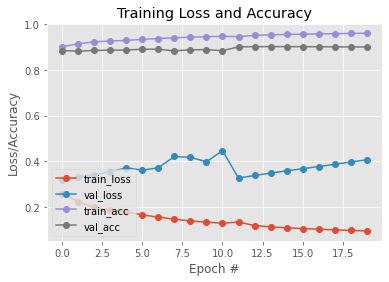

In [148]:
plot_leraning_curve((history))

### 4. 모델 평가

In [149]:
model.evaluate(valid_ds)

149/149 [==============================] - 24s 158ms/step - loss: 0.4063 - accuracy: 0.8997


[0.4062812030315399, 0.8996909856796265]

### 5. 추론

In [ ]:
3